# Regression

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import tvar
from matplotlib import pyplot as plt


(-5.0, 5.0)

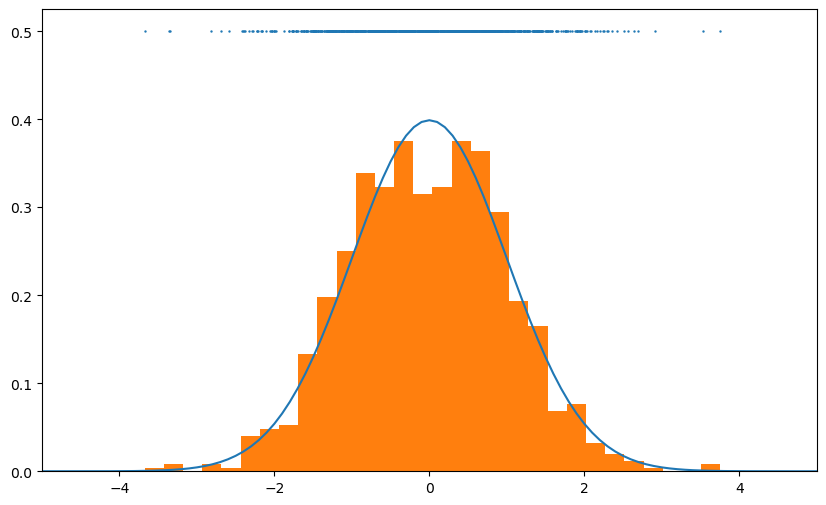

In [2]:
# generate Gaussian RVs

totalcounts = 1000
x = np.arange(-10,10,0.1)
rvs_normal = norm.rvs(size=totalcounts)
fig = plt.figure(figsize=(10,6))
plt.plot(x,norm.pdf(x))
n, bins, _ = plt.hist(rvs_normal,bins=30,density=True)
plt.scatter(rvs_normal,0.5*np.ones_like(rvs_normal),s=0.5)
plt.xlim(-5,5)

In [3]:
# estimate of mean and its uncertainty

mu_est = np.mean(rvs_normal) # sample mean estimator
mu_std = (tvar(rvs_normal)/len(rvs_normal))**0.5 # remember the mean estimator variance S^2/n
print(mu_est,mu_std,'two-sigma bound (',mu_est-2*mu_std,',',mu_est+2*mu_std,')')

-0.023427785692112117 0.032096633110425266 two-sigma bound ( -0.08762105191296266 , 0.040765480528738414 )


- In observations, a spectrum is typically binned, where we have counts or intensity in a channel (or R number).
- We fit Gaussian to the binned spectrum (histogram) with a mean and a variance.
- How do we estimate the uncertainty in our Gaussian fitting?
- Still follow the above reasoning, we can treat each bin as a number of RVs with the same measured value.
- So the estimated mean is a weighted mean of the bins.
- The sample variance is a weighted sum of the bin variance.
- But we still need the total count to get $S^2/n$ or $S/\sqrt n$.
- This is an approximation.

In [4]:
# use the histogram, we typically see in observations

bincenters = (bins[1:]+bins[:-1])/2.
mu_est1 = np.average(bincenters,weights=n)
mu_std1 = (np.sum(n*(bins[1]-bins[0])*(bincenters-mu_est1)**2)/totalcounts)**0.5 # approximately
print(mu_est1,mu_std1,bins[1]-bins[0])

-0.024550521305573173 0.03216160275016372 0.24762539979697396


- The standard deviation is much smaller than the bin size.
- Here we simply use the `totalcounts` for the denominator.
- How do we know the totalcounts in observation?

# Density Estimation

- So far, we have learned parametric estimation of density functions.
- Sometimes, we don't have a good model to start with.
- We use nonparametric methods to estimate the density to have a first look of the data.
- Then, we may or may not follow up with model descriptions.

Hereafter, we are going to estimate density using different methods.   

Firstly, we will apply **Kernal Density Estimation (KDE)** with different kernels (Gaussian, top-hat, and exponential kernels).

Secondly, we will use **K-Nearest-Neighbor Estimation** with different structure scales (different K values). 
  
Lastly, we will use **Gaussian Mixture Model (GMM)** which is parametric estimation.

(-5.0, 8.0)

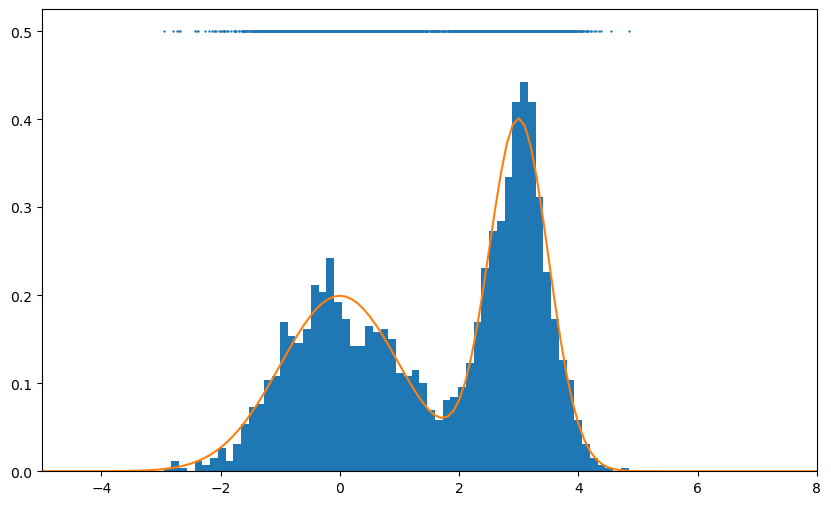

In [5]:
# We create a mixture of two Gaussians

rvs_normal1 = norm.rvs(size=1000)
rvs_normal2 = norm.rvs(loc=3,scale=0.5,size=1000)
rvs_mix = np.concatenate((rvs_normal1,rvs_normal2))
fig = plt.figure(figsize=(10,6))
n, bins, _ = plt.hist(rvs_mix,bins=60,density=True)
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
x = np.arange(-10,20,0.1)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5))
plt.xlim(-5,8)

## Evaluate KDE with Gaussian Kernel

- The histogram is subject to the uncertainty from the choice of bins.
- We can use KDE to estimate the density distribution using all available points.
- The estimator is
$$\hat{f_{N}}(x) = \frac{1}{Nh^D} \sum_{i=1}^{N} K(\frac{d(x,x_i)}{h})$$
where D is the dimensions of the parameter space, $N$ is the total number of points, $x_i$ is the RVs.

First, we use a *Gaussian kernel* to evaluate the kernel density. The function $K(u)$, a smooth function, represents the weight at a given point, which is normalized such that $\int K(u)du = 1$.  
The expression for Gaussian kernel is 

$$K(u) = \frac{1}{ {(2\pi)}^{D/2} } e^{\frac{-{u}^2}{2}}$$  

where D is the number of dimensions of the parameter space and $u = d(x, x_i) /h$.

For 1D case,
$$\hat{f_{N}}(x) = \frac{1}{Nh} \sum_{i=1}^{N} \frac{1}{ {(2\pi)}^{1/2} } e^{-\frac{{(x-x_i)^2/h}^2}{2}}$$

It is easy to show
$$\int \hat{f_{N}}(x) dx = \int \frac{1}{Nh} \sum_{i=1}^{N} \frac{1}{ {(2\pi)}^{1/2} } e^{\frac{-{u}^2}{2}} dx = \frac{1}{N}\int \sum_{i=1}^{N} \frac{1}{ {(2\pi)}^{1/2} } e^{\frac{-{u}^2}{2}} du = 1,$$
and
$$\int x\hat{f_{N}}(x) dx = \frac{1}{N} \sum_{i=1}^{N} \int x\frac{1}{ {(2\pi)}^{1/2} } e^{\frac{-{u}^2}{2}} du = \frac{1}{N} \sum_{i=1}^{N} \left(\int u\frac{1}{ {(2\pi)}^{1/2} } e^{\frac{-{u}^2}{2}} du + x_i\int \frac{1}{ {(2\pi)}^{1/2} } e^{\frac{-{u}^2}{2}} du\right) = \bar x.$$

So for a single-Gaussian underlying distribution, the expectation of the KDE is just the estimator of the mean.

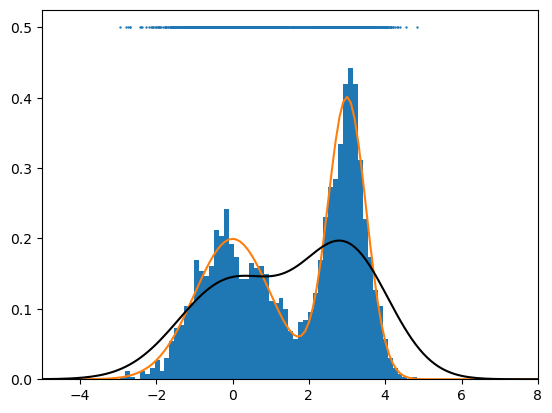

In [6]:
# now we use the KDE to estimate the above two-Gaussian mixture model
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=1, kernel='gaussian')
log_dens = kde.fit(rvs_mix[:,np.newaxis]).score_samples(x[:,np.newaxis])
dens = np.exp(log_dens)
n, bins, _ = plt.hist(rvs_mix,bins=60,density=True)
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
x = np.arange(-10,20,0.1)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5))
plt.xlim(-5,8)
plt.plot(x,dens,'k-')

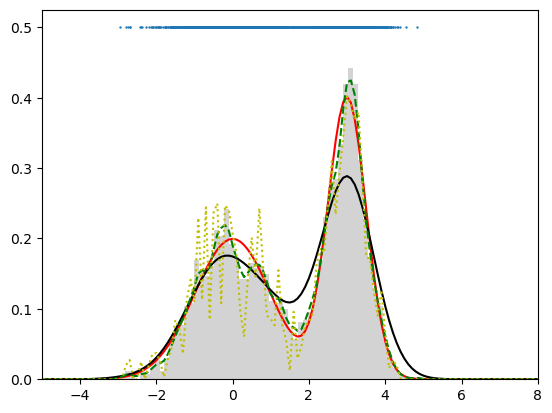

In [7]:
# try a narrower band

kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
log_dens = kde.fit(rvs_mix[:,np.newaxis]).score_samples(x[:,np.newaxis])
dens = np.exp(log_dens)
n, bins, _ = plt.hist(rvs_mix,bins=60,density=True,color='lightgray')
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
x = np.arange(-10,20,0.1)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5),'r-')
plt.xlim(-5,8)
plt.plot(x,dens,'k-')

kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
log_dens = kde.fit(rvs_mix[:,np.newaxis]).score_samples(x[:,np.newaxis])
dens = np.exp(log_dens)
plt.plot(x,dens,'g--')

kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
log_dens = kde.fit(rvs_mix[:,np.newaxis]).score_samples(x[:,np.newaxis])
dens = np.exp(log_dens)
plt.plot(x,dens,'y:')

- How do we choose the optimal band?
- We can use the cross-validation method by maximizing the log likelihood:
$$CV(h) = \frac{1}{N} \sum_{i=1}^{N} log\hat{f_{h,-i}}(x_i)$$
where $-i$ means leaving out the i-th point from the estimator.

In [8]:
# implement our CV method
from sklearn.model_selection import LeaveOneOut

def cv(h,X,ker):
    kde = KernelDensity(bandwidth=h, kernel=ker)
    logf = 0.
    loo = LeaveOneOut()
    for train_id, test_id in loo.split(X): # gives training and testing indices
        train = X[train_id]
        test = X[test_id]
        log_dens = kde.fit(train[:,np.newaxis]).score_samples(test[:,np.newaxis])
        logf += log_dens
    return logf/len(X)

0.01 [-2.14944158]
0.016681005372000592 [-1.87146709]
0.027825594022071243 [-1.76713798]
0.046415888336127774 [-1.72588113]
0.0774263682681127 [-1.70857878]
0.1291549665014884 [-1.70094963]
0.21544346900318834 [-1.69997073]
0.3593813663804626 [-1.7122789]
0.5994842503189409 [-1.76172732]
1.0 [-1.8729752]


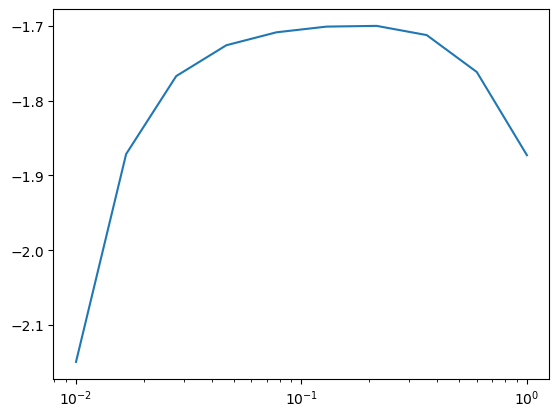

In [9]:
# compute CV

CVs = []
testh = np.logspace(-2,0,num=10)
for h in testh:
    CVtemp = cv(h,rvs_mix,'gaussian')
    print(h,CVtemp)
    CVs.append(CVtemp)
    
plt.plot(testh,CVs)
plt.xscale('log')

- It looks like our choice of 0.1 is not bad.
- If we want to be more rigorous we need maximization (minimization) algorithms (Prof. Chan's lectures!).
- The CV method can be slow, alternatives include k-fold method.
- In principle we can use parallel computing.

## Evaluate KDE with Top-hat Kernel
Now we use a *top-hat (box) kernel* to evaluate the kernel density. The expression for top-hat kernel is 

$$f(z) = \left\{ \begin{array}{rcl}
\frac{1}{V_{D}(1)} & \mbox{if} & |u|\leq1, \\
0 & \mbox{if} & |u|>1.
\end{array}\right.$$  

This kernel gives the most "spread out" estimation for each distribution freature.

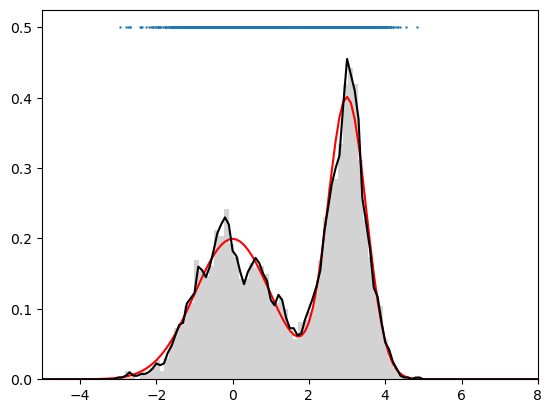

In [10]:
kde = KernelDensity(bandwidth=0.1, kernel='tophat')
log_dens = kde.fit(rvs_mix[:,np.newaxis]).score_samples(x[:,np.newaxis])
dens = np.exp(log_dens)
n, bins, _ = plt.hist(rvs_mix,bins=60,density=True,color='lightgray')
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
x = np.arange(-10,20,0.1)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5),'r-')
plt.xlim(-5,8)
plt.plot(x,dens,'k-')

0.01 [0.21393197]
0.016681005372000592 [0.21514257]
0.027825594022071243 [0.21517038]
0.046415888336127774 [0.21649967]
0.0774263682681127 [0.21733441]
0.1291549665014884 [0.21742904]
0.21544346900318834 [0.2160684]
0.3593813663804626 [0.2118072]
0.5994842503189409 [0.20120597]
1.0 [0.18039795]


(0.01, 1.0)

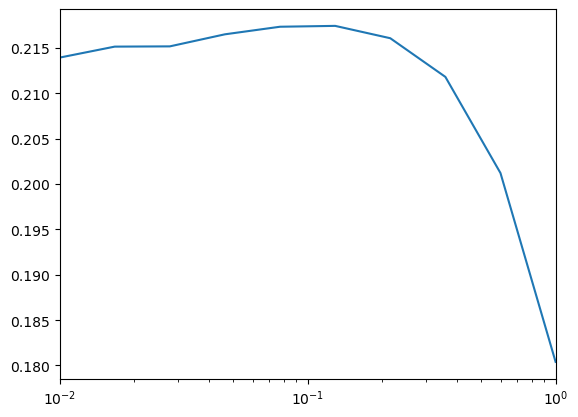

In [11]:
# It's too noisy, let's find out the best band using CV again

def cv_tophat(h,X,ker):
    kde = KernelDensity(bandwidth=h, kernel=ker)
    f = 0.
    loo = LeaveOneOut()
    for train_id, test_id in loo.split(X): # gives training and testing indices
        train = X[train_id]
        test = X[test_id]
        log_dens = kde.fit(train[:,np.newaxis]).score_samples(test[:,np.newaxis])
        f += np.exp(log_dens)
    return f/len(X)

CVs_tophat = []
for h in testh:
    CVtemp = cv_tophat(h,rvs_mix,'tophat')
    print(h,CVtemp)
    CVs_tophat.append(CVtemp)
    
plt.plot(testh,CVs_tophat)
plt.xscale('log')
plt.xlim(min(testh),max(testh))

## Evaluate KDE with Exponential Kernel
Now let's use a *exponential kernel* to evaluate the kernel density. The expression for exponential kernel is 

$$K(u) = \frac{1}{D!V_{D}(1)}e^{-|u|}.$$  

where $V_D(r)$ is the volume of a D-dimensional hypersphere of radius r.  
This kernel gives the "sharpest" estimation for each distribution feature.  

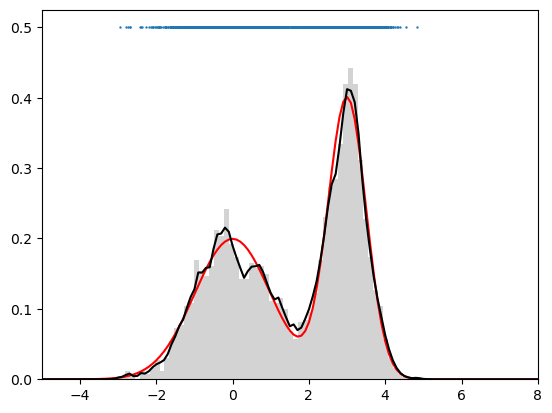

In [12]:
kde = KernelDensity(bandwidth=0.1, kernel='exponential')
log_dens = kde.fit(rvs_mix[:,np.newaxis]).score_samples(x[:,np.newaxis])
dens = np.exp(log_dens)
n, bins, _ = plt.hist(rvs_mix,bins=60,density=True,color='lightgray')
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
x = np.arange(-10,20,0.1)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5),'r-')
plt.xlim(-5,8)
plt.plot(x,dens,'k-')

0.01 [-1.78522096]
0.016681005372000592 [-1.74950225]
0.027825594022071243 [-1.72795931]
0.046415888336127774 [-1.714405]
0.0774263682681127 [-1.70583361]
0.1291549665014884 [-1.70158287]
0.21544346900318834 [-1.70547326]
0.3593813663804626 [-1.72993756]
0.5994842503189409 [-1.7922324]
1.0 [-1.90071167]


(0.01, 1.0)

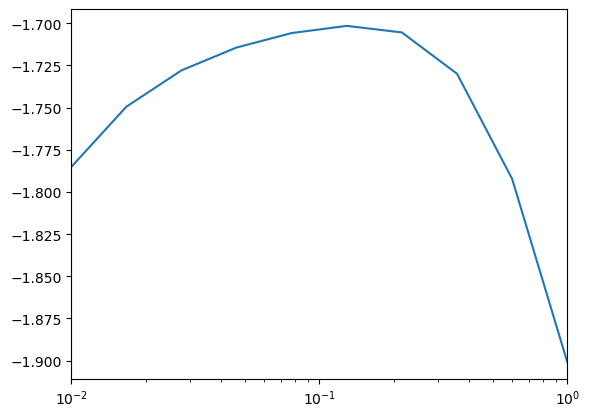

In [13]:
# let's find out the best band using CV again

CVs_expo = []
for h in testh:
    CVtemp = cv(h,rvs_mix,'exponential')
    print(h,CVtemp)
    CVs_expo.append(CVtemp)
    
plt.plot(testh,CVs_expo)
plt.xscale('log')
plt.xlim(min(testh),max(testh))

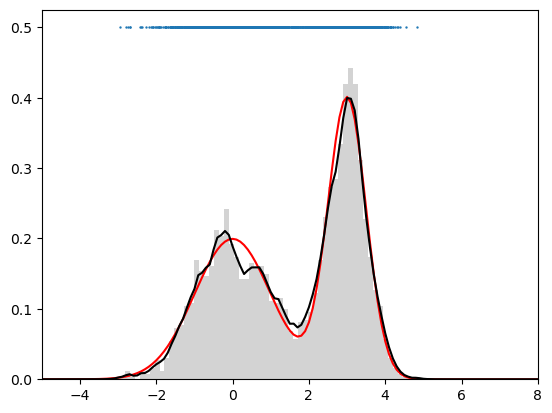

In [14]:
kde = KernelDensity(bandwidth=0.129, kernel='exponential')
log_dens = kde.fit(rvs_mix[:,np.newaxis]).score_samples(x[:,np.newaxis])
dens = np.exp(log_dens)
n, bins, _ = plt.hist(rvs_mix,bins=60,density=True,color='lightgray')
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
x = np.arange(-10,20,0.1)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5),'r-')
plt.xlim(-5,8)
plt.plot(x,dens,'k-')

## Evaluate density using K-Nearest-Neighbor Estimation
Another estimator is the K-nearest-neighbor estimator, originally proposed by [Dressler et al. 1980](https://ui.adsabs.harvard.edu/abs/1980ApJ...236..351D/abstract) . In this method, the implied point density at an arbitrary position x is estimated as

$$\hat{f_K}(x) = \frac{K}{V_D(d_K)}$$

where $V_D$ is evaluated volume, and D is the problem dimensionality.  
  
By taking the assumption that the underlying density field is locally constant, we can further simplify this method as

$$\hat{f_K}(x) = \frac{C}{d_K^D}$$

where C is a scaling factor evaluated by requiring that the sum of the product of $\hat{f_K}(x)$ and
pixel volume is equal to the total number of data points.

In this method, we can change parameter k to get different estimation result.
K should be at least 5 because the estimator is biased and has a large variance for smaller K; see [Casertano, S. and Hut, P.](https://ui.adsabs.harvard.edu/abs/1985ApJ...298...80C/abstract)

In [ ]:
from astroML.density_estimation import KNeighborsDensity

# calculate K Neighbors Density with k = 5
knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(rvs_mix[:,np.newaxis]).eval(x[:,np.newaxis])/len(rvs_mix)

n, bins, _ = plt.hist(rvs_mix,bins=60,density=True)
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5))
plt.xlim(-5,8)
plt.plot(x,dens_k5,'k-')

In [ ]:
# calculate K Neighbors Density with k = 40
knn5 = KNeighborsDensity('bayesian', 40)
dens_k5 = knn5.fit(rvs_mix[:,np.newaxis]).eval(x[:,np.newaxis])/len(rvs_mix)

n, bins, _ = plt.hist(rvs_mix,bins=60,density=True)
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5))
plt.xlim(-5,8)
plt.plot(x,dens_k5,'k-')

## Use Gaussian Mixture Model
GMM calculate the underlying pdf of a point as a sum of Gaussians using the equation below

$$p(x) = \sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$$

where M is the number of Gaussians, $\mu_j$ is the the location, and $\Sigma_j$ is the covariance of a Gaussian.

In [ ]:
from sklearn.mixture import GaussianMixture

def compute_GMM(X, n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    print("converged:", clf.converged_)
    return clf

In [ ]:
# Calculate GMM

clf = compute_GMM(rvs_mix[:,np.newaxis],n_clusters=2)
log_dens = clf.score_samples(x[:,np.newaxis])

n, bins, _ = plt.hist(rvs_mix,bins=60,density=True)
plt.scatter(rvs_mix,0.5*np.ones_like(rvs_mix),s=0.5)
plt.plot(x,0.5*norm.pdf(x)+0.5*norm.pdf(x,loc=3,scale=0.5))
plt.xlim(-5,8)
plt.plot(x,np.exp(log_dens),'k-')

- We get a decent fit which is not surprising because we know we set up a mixture of two Gaussians!
- Practically our data is (very) likely not a simple combination of Gaussians.
- But nothing is stopping us from using multiple Gaussians to describe the data.
- An example: https://ui.adsabs.harvard.edu/abs/2019A%26A...628A..78R/abstract

## Examples in 2D

1. Download the notebook from astroML: https://www.astroml.org/astroML-notebooks/chapter6/astroml_chapter6_Density_Estimation_for_SDSS_Great_Wall.html
2. Apply the KDE method to the exoplanet demography (data in 'exoplanet.csv' from https://exoplanetarchive.ipac.caltech.edu).